In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams

import sys
import os
import glob2
from tqdm import tqdm

import ast
import pandas as pd

from chatty_boi import *

In [2]:
with open("./prompt_lib_swr/base_prompt_swr.txt", "r") as f:
    prompt = f.read()

with open("./prompt_lib_swr/constraint_prompt_swr.txt", "r") as f:
    constraints_prompt = f.read()

with open("./prompt_lib_swr/optimize_prompt_swr.txt", "r") as f:
    optimize_prompt = f.read()

input_data = {}
with open("./prompt_lib_swr/base_inputs_swr.txt", "r") as f:
    exec(f.read(),{}, input_data)


base_prompt = prompt
constraints_prompt = constraints_prompt
optimize_prompt = optimize_prompt

node_dict_input = input_data["node_dict_input"]
example_members_input = input_data["example_members_input"]
area_id = input_data["area_id"]
load = input_data["load"]
supports = input_data["supports"]


In [3]:
# Find all files matching the pattern in subfolders run_{j} and inside runs folder _step_{iteration}_{attempt}
import re

base_dir = './results_final_runs/responses_q2/'
pattern = os.path.join(base_dir, '*', 'run_*', '_step_*_*')
all_files = glob2.glob(pattern)

# Organize files by their parent directories (the folder inside ./responses)
file_dict = {}
for f in all_files:
    parts = f.split(os.sep)
    if len(parts) < 4:
        continue
    parent = parts[3]  # e.g., q1p1_s15W30_nano_t1
    # print(parent)
    run_folder = parts[4]  # e.g., run_1
    if parent not in file_dict:
        file_dict[parent] = {}
    if run_folder not in file_dict[parent]:
        file_dict[parent][run_folder] = []
    file_dict[parent][run_folder].append(f)

# Optionally, sort the files within each run folder
for parent in file_dict:
    for run_folder in file_dict[parent]:
        file_dict[parent][run_folder].sort()

# Convert to DataFrame for display
rows = []
for parent, runs in file_dict.items():
    for run, files in runs.items():
        for file in files:
            rows.append({'parent': parent, 'run': run, 'file': file})
df_files = pd.DataFrame(rows)


In [4]:
# Get all files for a given parent and run, sorted by step number
import re

def extract_step_number(filename):
    # Matches _step_{step}_{attempt} (step can be multiple digits)
    m = re.search(r'_step_(\d+)_', os.path.basename(filename))
    return int(m.group(1)) if m else -1

def get_files_for_parent_run(parent, run):
    files = file_dict.get(parent, {}).get(run, [])
    return sorted(files, key=extract_step_number)

def get_sorted_runs_for_parent(parent):
    runs = file_dict.get(parent, {}).keys()
    return sorted(runs, key=lambda x: int(x.split("_")[1]))


In [9]:
# Example usage:
parent = 'q2p2_s075W30_gpt_t1'  # replace with desired parent
# run = 'run_6'                   # replace with desired run
# files = get_files_for_parent_run(parent, run)
# print(files)
# rr = df_files[df_files['parent'] == parent]
# sorted_runs = sorted(rr["run"].unique(), key=lambda x: int(x.split("_")[1]))
# sorted_runs 

sorted_runs = get_sorted_runs_for_parent(parent)
print(sorted_runs)


# for j in sorted_runs:
#     files = get_files_for_parent_run(parent, j)
#     print(files)


    

['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']


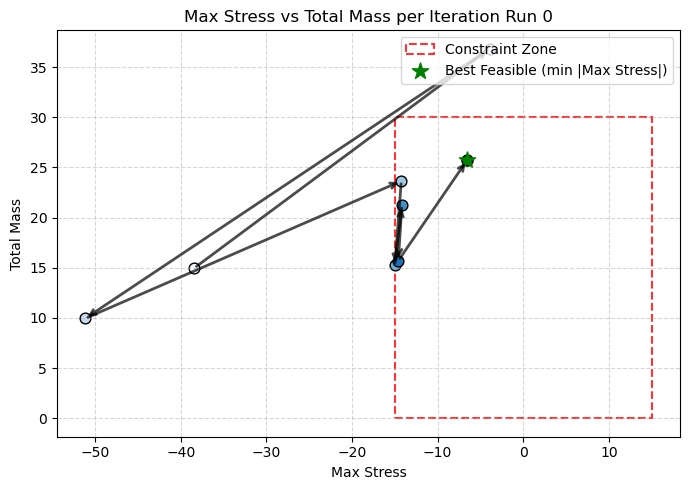

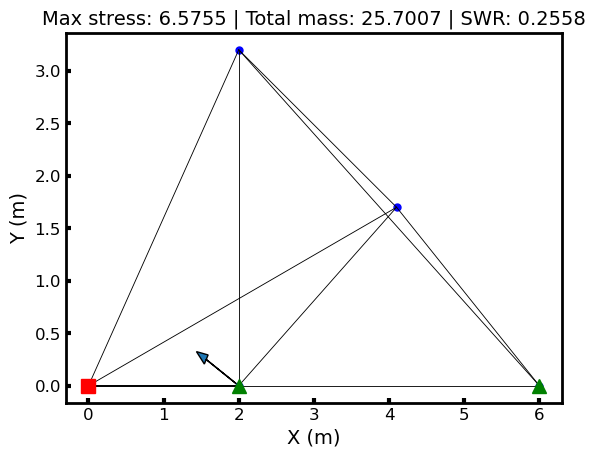

min_idx: 7
None
./results_final_runs/responses_q2/q2p2_s075W30_gpt_t1/run_0/_step_7_1.txt
------------------------------------------------------------------------/n


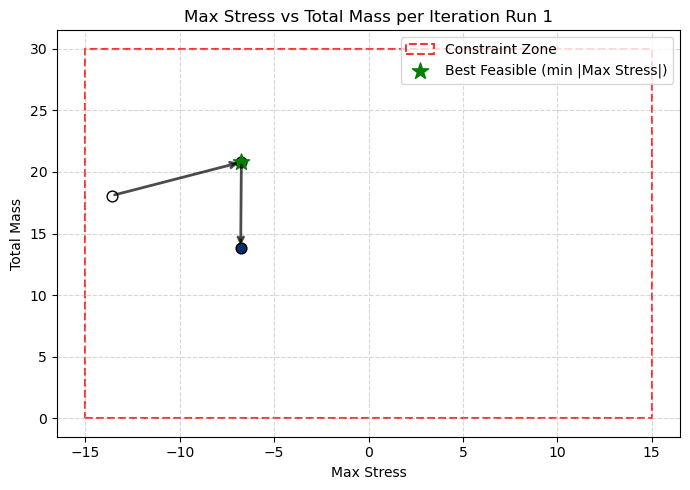

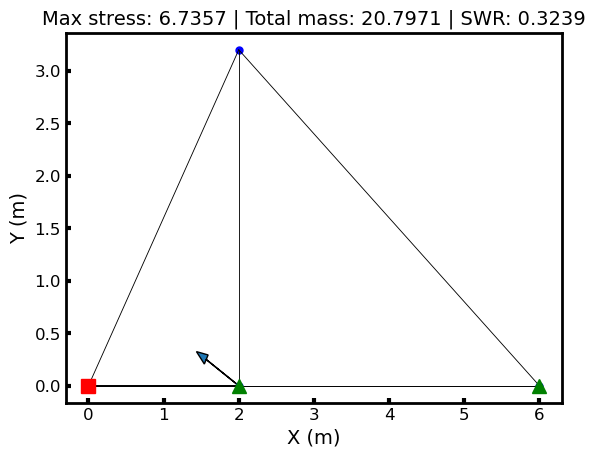

min_idx: 1
None
./results_final_runs/responses_q2/q2p2_s075W30_gpt_t1/run_1/_step_1_0.txt
------------------------------------------------------------------------/n


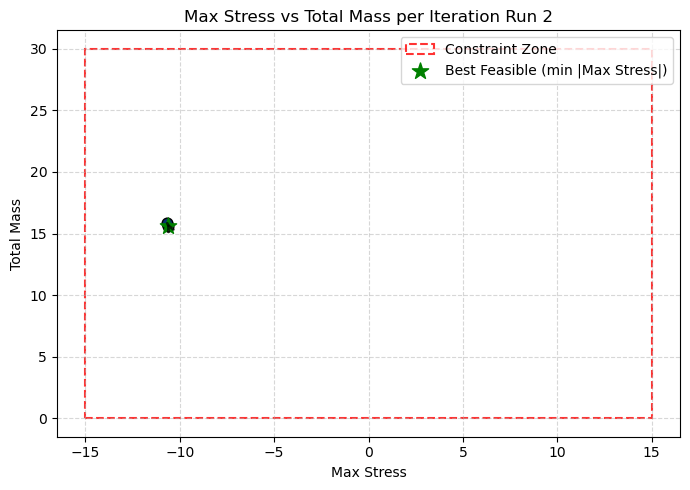

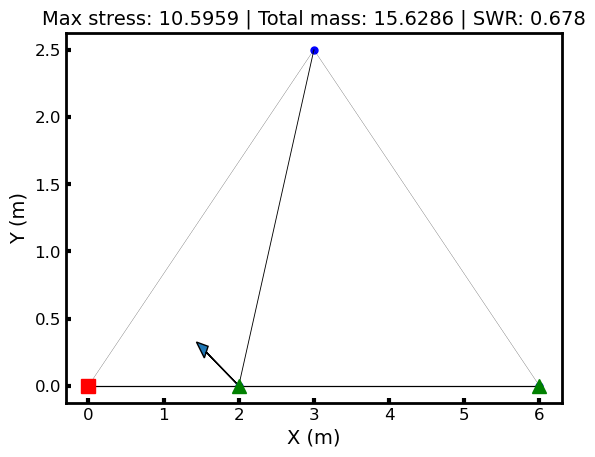

min_idx: 0
None
./results_final_runs/responses_q2/q2p2_s075W30_gpt_t1/run_2/_step_0_0.txt
------------------------------------------------------------------------/n


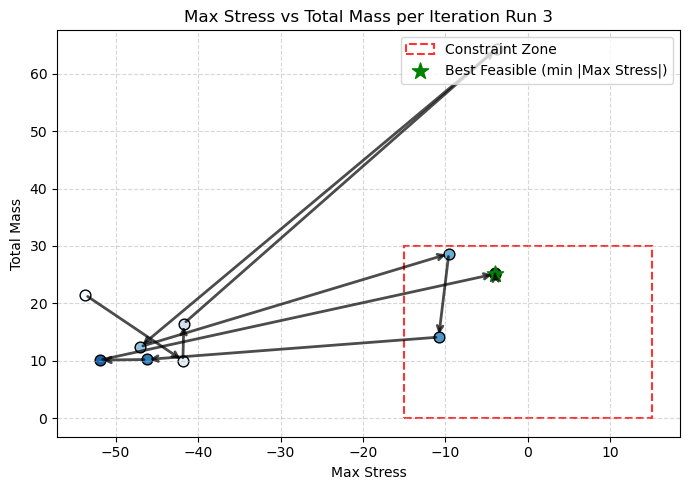

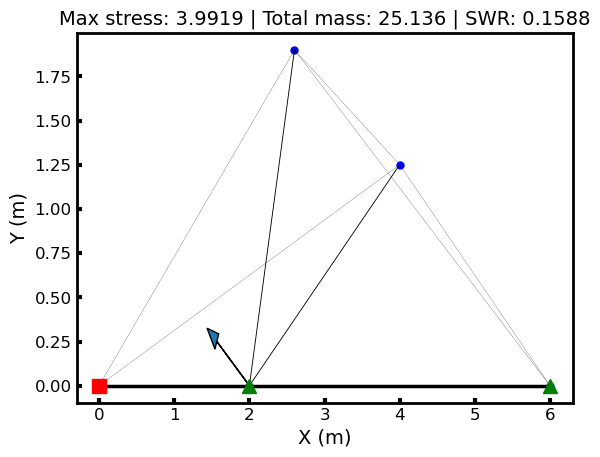

min_idx: 9
None
./results_final_runs/responses_q2/q2p2_s075W30_gpt_t1/run_3/_step_9_1.txt
------------------------------------------------------------------------/n


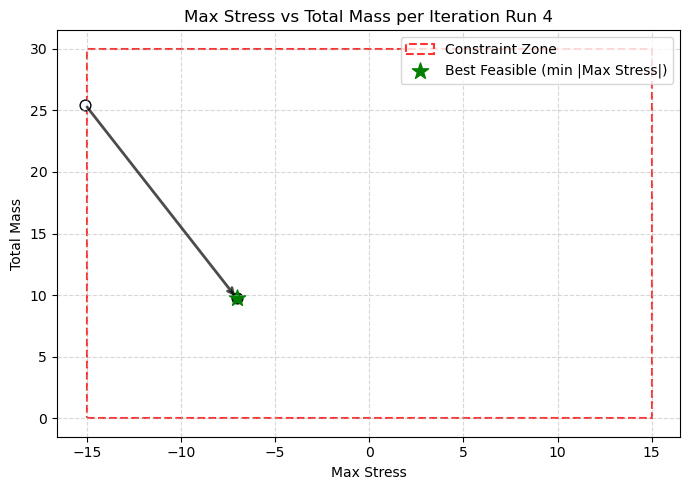

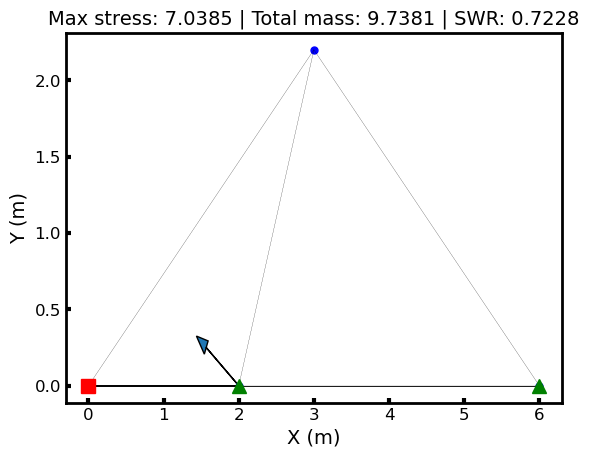

min_idx: 1
None
./results_final_runs/responses_q2/q2p2_s075W30_gpt_t1/run_4/_step_1_0.txt
------------------------------------------------------------------------/n


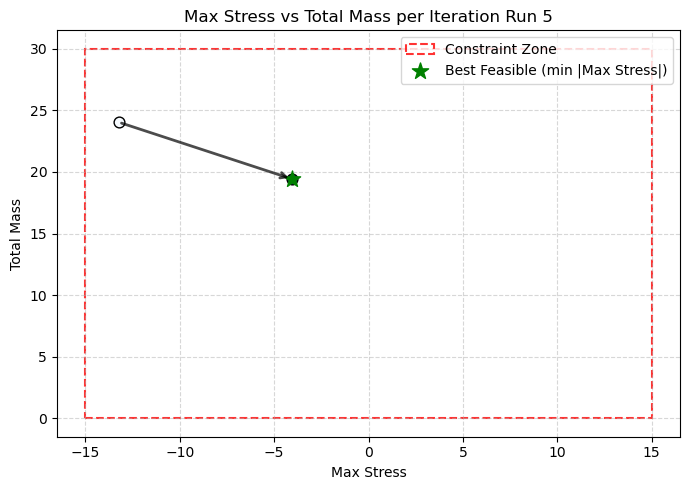

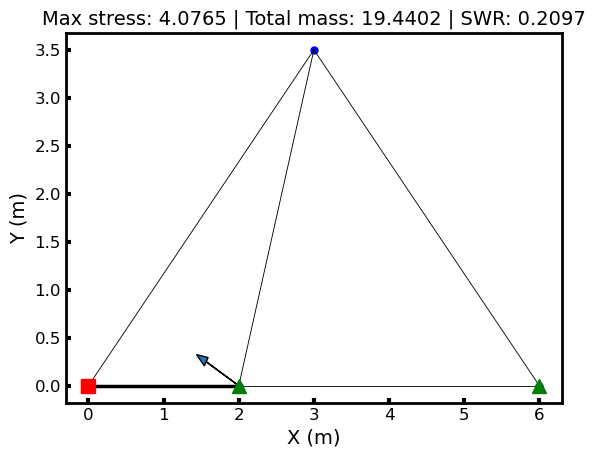

min_idx: 1
None
./results_final_runs/responses_q2/q2p2_s075W30_gpt_t1/run_5/_step_1_0.txt
------------------------------------------------------------------------/n


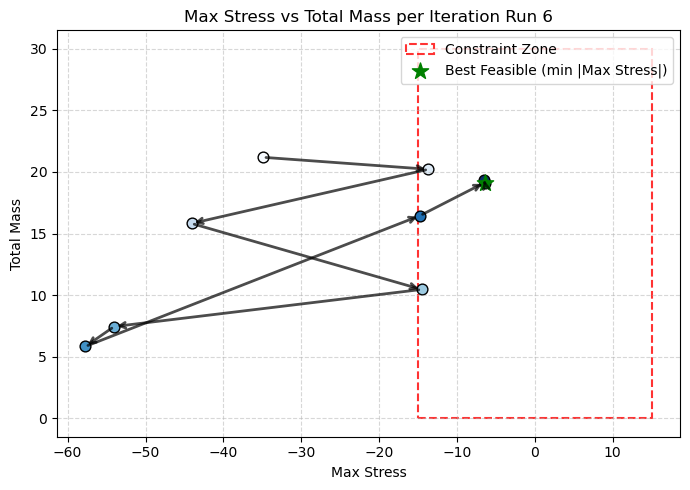

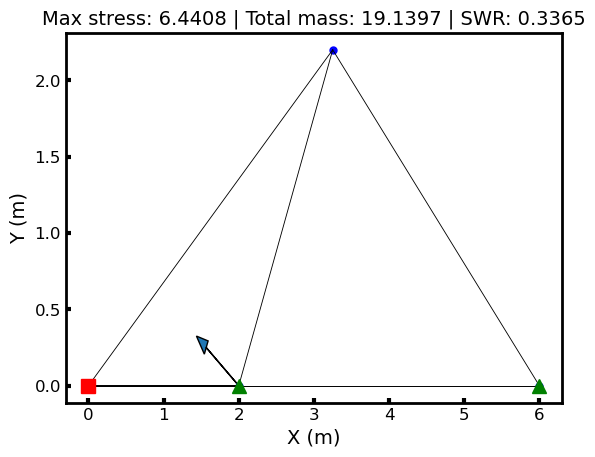

min_idx: 7
None
./results_final_runs/responses_q2/q2p2_s075W30_gpt_t1/run_6/_step_7_2.txt
------------------------------------------------------------------------/n


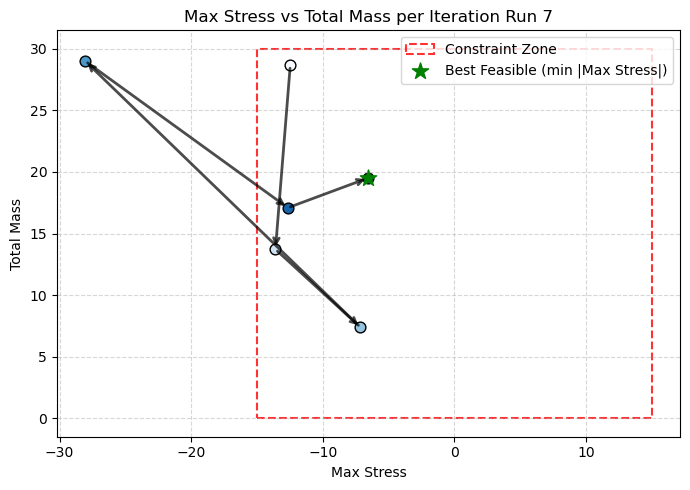

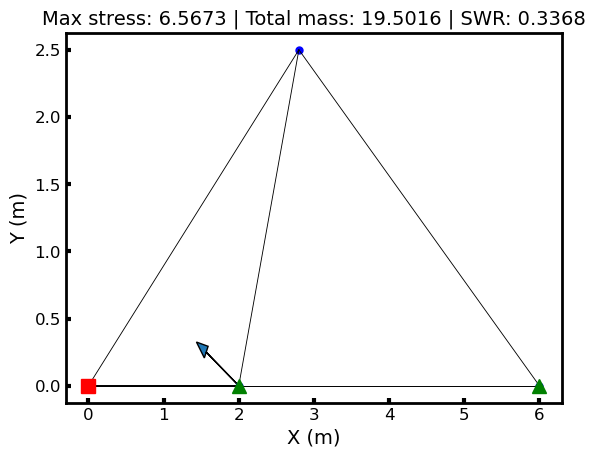

min_idx: 5
None
./results_final_runs/responses_q2/q2p2_s075W30_gpt_t1/run_7/_step_5_0.txt
------------------------------------------------------------------------/n


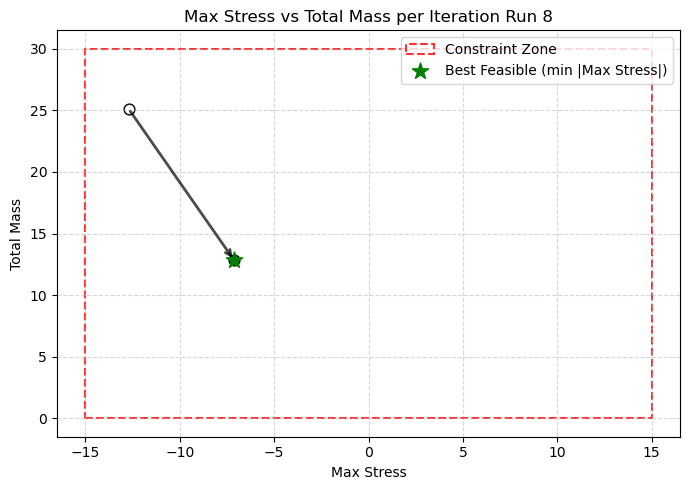

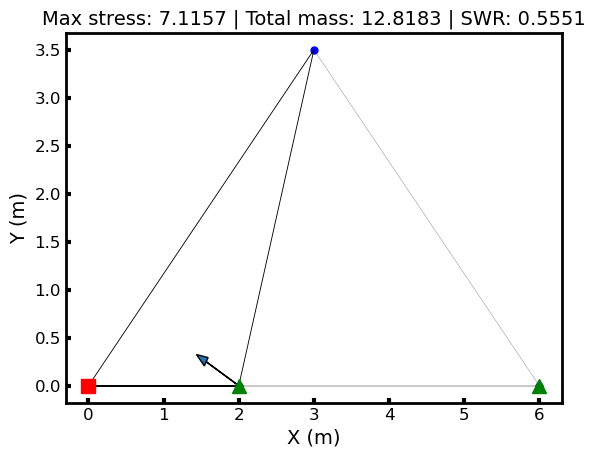

min_idx: 1
None
./results_final_runs/responses_q2/q2p2_s075W30_gpt_t1/run_8/_step_1_0.txt
------------------------------------------------------------------------/n


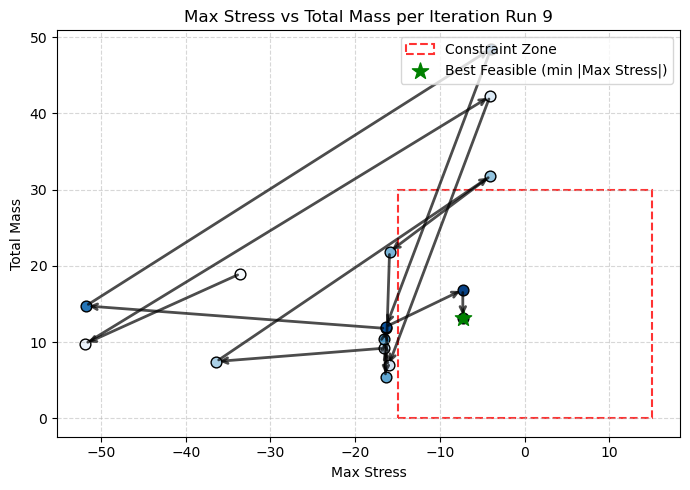

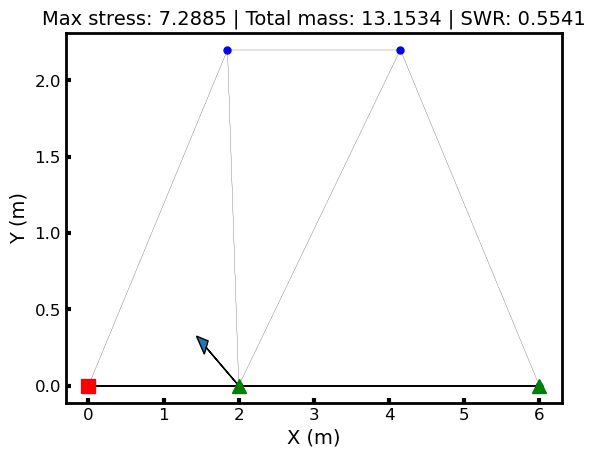

min_idx: 15
None
./results_final_runs/responses_q2/q2p2_s075W30_gpt_t1/run_9/_step_15_0.txt
------------------------------------------------------------------------/n


In [10]:
analysis_dict = {}
for j in sorted_runs:
    files = get_files_for_parent_run(parent, j)

    r={}
    stress_max_r = {}
    mass_total_r = {}

    for i in (range(len(files))):
        # Read the file
        with open(files[i], 'r') as f:
            data = f.read()
        
        gen_dict = (ast.literal_eval(data))
        parsed_output = TrussOutput.model_validate(gen_dict)
        node_dict_g = parsed_output.node_dict
        member_dict_g = parsed_output.member_dict
        t_gen = make_truss(node_dict_g, member_dict_g, load, supports)
        # plot_truss(t_gen)
        res, result_dict = make_result_dict(t_gen.member_stress(), t_gen.structure_mass(), print_= False)

        r[i] = result_dict
        stress_max_r[i] = max(result_dict["member_stress"].values(), key=lambda x: abs(x))
        mass_total_r[i] = result_dict["total_mass"]



    max_stress_allow = 15   # example value, set as needed
    total_mass_allow = 30  # example value, set as needed

    steps = np.arange(len(stress_max_r))
    stress_vals = [stress_max_r[i] for i in steps]
    mass_vals = [mass_total_r[i] for i in steps]

    # Find the index of the min(abs(max stress)) (keep sign)
    min_idx = np.argmin(np.abs(stress_vals))
    

    # Find all indices that satisfy constraints
    feasible_indices = [i for i in steps if abs(stress_vals[i]) <= max_stress_allow and mass_vals[i] <= total_mass_allow]
    if feasible_indices:
        min_feas_idx = min(feasible_indices, key=lambda i: abs(stress_vals[i]))
    else:
        min_feas_idx = None

    # Normalize steps for colormap
    norm = plt.Normalize(steps.min(), steps.max())
    cmap = plt.cm.Blues
    colors = cmap(norm(steps))

    fig, ax = plt.subplots(figsize=(7,5))

    # Draw constraint zone as a rectangle
    rect = plt.Rectangle((-max_stress_allow, 0), 2*max_stress_allow, total_mass_allow,
                        linewidth=1.5, edgecolor='red', facecolor='none', linestyle='--', alpha=0.8, label='Constraint Zone')

    # plt.xlim(-100, 100)
    # plt.ylim(0, 50)

    ax.add_patch(rect)

    for k in steps:
        ax.scatter(stress_vals[k], mass_vals[k], color=colors[k], s=60, edgecolor='k')

    if min_feas_idx is not None:
        if abs(stress_vals[min_feas_idx]) <= max_stress_allow and mass_vals[min_feas_idx] <= total_mass_allow:
            ax.scatter(stress_vals[min_feas_idx], mass_vals[min_feas_idx], color='g', marker='*', s=150, label='Best Feasible (min |Max Stress|)')

    # Draw arrows from each step to the next
    for p in range(len(steps)-1):
        ax.annotate('',
                    xy=(stress_vals[p+1], mass_vals[p+1]),
                    xytext=(stress_vals[p], mass_vals[p]),
                    arrowprops=dict(arrowstyle='->', lw=2, alpha=0.7))

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    ax.set_xlabel('Max Stress')
    ax.set_ylabel('Total Mass')
    ax.set_title(f'Max Stress vs Total Mass per Iteration Run {j.split("_")[1]}')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # --- Analysis dict for best design (min abs stress, red star) ---
    # Use min_idx (red star, not necessarily feasible)
    best_file = files[min_feas_idx]
    with open(best_file, 'r') as f:
        best_data = f.read()
    best_gen_dict = (ast.literal_eval(best_data))
    best_parsed_output = TrussOutput.model_validate(best_gen_dict)
    best_node_dict = best_parsed_output.node_dict
    best_member_dict = best_parsed_output.member_dict
    num_nodes = len(best_node_dict)
    num_connections = len(best_member_dict)
    analysis_dict[j] = {
        'num_nodes': num_nodes,
        'num_connections': num_connections,
        'node_dict': best_node_dict,
        'member_dict': best_member_dict,
        "structure": make_truss(best_node_dict, best_member_dict, load, supports),
    }

    plot_truss(analysis_dict[j]["structure"])
    print(print(f"min_idx: {min_feas_idx}"))
    print(files[min_feas_idx])

    print("------------------------------------------------------------------------/n")

# analysis_dict now contains number of nodes and connections for each run's best design (red star)